# Image Search Engine - Search images in target directory to find simillar images in sourcr directory

# Mount our google drive to use uploaded data in google drive into colab

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


# Import neccessary liberaries

In [2]:
import numpy as np
from numpy.linalg import norm
from tqdm import tqdm, tqdm_notebook
import pickle
import os
import time
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, GlobalAveragePooling2D

# Load Feature Extractor model

In [3]:
def model_picker(name):
  if (name == 'vgg16'):
    model = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3),
                  pooling='max')

  elif (name == 'vgg19'):
    model = VGG19(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3),
                  pooling='max')

  elif (name == 'mobilenet'):
    model = MobileNet(weights='imagenet',
                      include_top=False,
                      input_shape=(224, 224, 3),
                      pooling='max',
                      depth_multiplier=1,
                      alpha=1)

  elif (name == 'inception'):
    model = InceptionV3(weights='imagenet',
                        include_top=False,
                        input_shape=(224, 224, 3),
                        pooling='max')

  elif (name == 'resnet'):
    model = ResNet50(weights='imagenet',
                     include_top=False,
                     input_shape=(224, 224, 3),
                     pooling='max')

  else:
    print("Specified model not available")

  return model

In [4]:
model_architecture = 'resnet'
model = model_picker(model_architecture)

94765736/94765736 [==============================] - 1s 0us/step


# Extract features for the entire dataset

## Get filename of all data in dataset directory

In [5]:
extensions = ['.jpg', '.JPG', '.jpeg', '.JPEG', '.png', '.PNG']

def get_file_list(root_dir):
  file_list = []
  for root, directories, filenames in os.walk(root_dir):
    for filename in filenames:
      if any(ext in filename for ext in extensions):
        filepath = os.path.join(root, filename)
        if os.path.exists(filepath):
          file_list.append(filepath)
        else:
          print(filepath)
  return file_list


In [6]:
# Path to the datasets
root_dir = '/content/drive/MyDrive/Datasets/test_task/source'
filenames = sorted(get_file_list(root_dir))
print(len(filenames))

254


## Extract features from files

In [7]:
def extract_features(img_path, model):
    input_shape = (224, 224, 3)
    img = image.load_img(img_path,
                         target_size=(input_shape[0], input_shape[1]))
    img_array = image.img_to_array(img)
    expanded_img_array = np.expand_dims(img_array, axis=0)
    preprocessed_img = preprocess_input(expanded_img_array)
    features = model.predict(preprocessed_img)
    flattened_features = features.flatten()
    normalized_features = flattened_features / norm(flattened_features)
    return normalized_features

In [8]:
# Features lenght that our model create
features = extract_features("/content/drive/MyDrive/Datasets/test_task/source/000d84aa-f4df-4870-af29-26b3391bbdc6.jpg", model)
print(len(features))

1/1 [==============================] - 2s 2s/step
2048


In [9]:
feature_list = []
for i in tqdm_notebook(range(len(filenames))):
  feature_list.append(extract_features(filenames[i], model))

<ipython-input-9-985bac69459c>:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(len(filenames))):


  0%|          | 0/254 [00:00<?, ?it/s]

1/1 [==============================] - 0s 313ms/step


# Similarity search

## PCA

In [42]:
import time
from sklearn.decomposition import PCA
import PIL
from PIL import Image
import glob
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

In [11]:
num_images = len(filenames)
num_features_per_image = len(feature_list[0])
print(f"Number of images = {num_images}")
print(f"Number of features per image = {num_features_per_image}")

Number of images = 254
Number of features per image = 2048


In [12]:
# Check what dimension is good for PCA

<ipython-input-13-7f13dd20e66b>:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  matplotlib.style.use('seaborn')


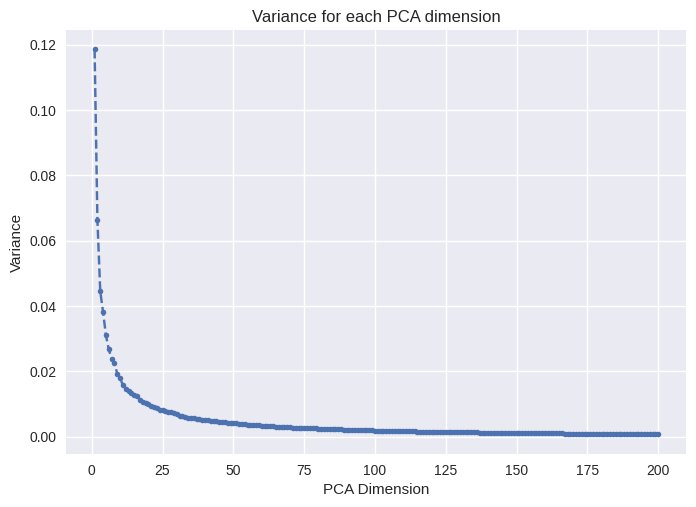

In [13]:
# Check trade-off between num-dimensions and variance
# n_components = min(num_images, len(features))
n_components = 200
pca = PCA(n_components)
pca.fit(feature_list)
matplotlib.style.use('seaborn')
plt.plot(range(1, n_components + 1), pca.explained_variance_ratio_, 'o--', markersize=4)
plt.title('Variance for each PCA dimension')
plt.xlabel('PCA Dimension')
plt.ylabel('Variance')
plt.grid(True)
plt.show()

In [17]:
# Number of features for similarity search after dimension reduction
num_feature_dimensions = 100

In [18]:
# Apply dimention reduction on feature_list using PCA
pca = PCA(n_components=num_feature_dimensions)
pca.fit(feature_list)
feature_list_compressed = pca.transform(feature_list)
feature_list_compressed = feature_list_compressed.tolist()

In [19]:
print(pca.explained_variance_ratio_[0:20])

[0.11856475 0.06629192 0.04454517 0.03816176 0.0310523  0.02676565
 0.02391104 0.02267455 0.0192701  0.01783527 0.01583068 0.01472138
 0.01411818 0.01343345 0.01264759 0.0125188  0.01123921 0.01076867
 0.0102774  0.00991485]


## Use Pinecone Vector-database for similarity search

In [20]:
! pip install pinecone-client

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.9/215.9 kB 1.8 MB/s eta 0:00:00


In [21]:
from pinecone import Pinecone, ServerlessSpec

API_KEY = "Your API-KEY from pinecone"

pc = Pinecone(api_key=API_KEY)

In [22]:
import os
CLOUD = os.environ.get('PINECONE_CLOUD') or 'aws'
REGION = os.environ.get('PINECONE_REGION') or 'us-east-1'

SPEC = ServerlessSpec(cloud=CLOUD, region=REGION)

In [23]:
# Create a severless index
import time

INDEX_NAME = "image-similarity"

existing_indexes = [
    index_info["name"] for index_info in pc.list_indexes()
]

# check if index already exists (it shouldn't if this is first time)
if INDEX_NAME not in existing_indexes:
    # if does not exist, create index
    pc.create_index(
        INDEX_NAME,
        dimension=num_feature_dimensions,  # dimensionality of minilm
        metric='cosine',
        spec=SPEC
    )
    # wait for index to be initialized
    while not pc.describe_index(INDEX_NAME).status['ready']:
        time.sleep(1)

# connect to index
index = pc.Index(INDEX_NAME)
time.sleep(1)
# view index stats
index.describe_index_stats()

{'dimension': 100,
 'index_fullness': 0.0,
 'namespaces': {},
 'total_vector_count': 0}

In [24]:
# index.delete(delete_all=True)

In [25]:
vectors = list(zip(filenames, feature_list_compressed))

In [26]:
# Insert our vectors with ids in database
for item in vectors:
  index.upsert([
      (os.path.basename(item[0]), item[1])
  ])

## Making Queries

In [28]:
# Path to the datasets
root_dir = '/content/drive/MyDrive/Datasets/test_task/target'
target_filenames = sorted(get_file_list(root_dir))
print(len(target_filenames))

5


In [29]:
target_feature_list = []
for i in tqdm_notebook(range(len(target_filenames))):
  target_feature_list.append(extract_features(target_filenames[i], model))

<ipython-input-29-5f0e8de1a6a8>:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(len(target_filenames))):


  0%|          | 0/5 [00:00<?, ?it/s]

1/1 [==============================] - 0s 198ms/step


In [30]:
# Apply dimension reduction on target features
target_feature_list_compressed = pca.transform(target_feature_list)
target_feature_list_compressed = target_feature_list_compressed.tolist()

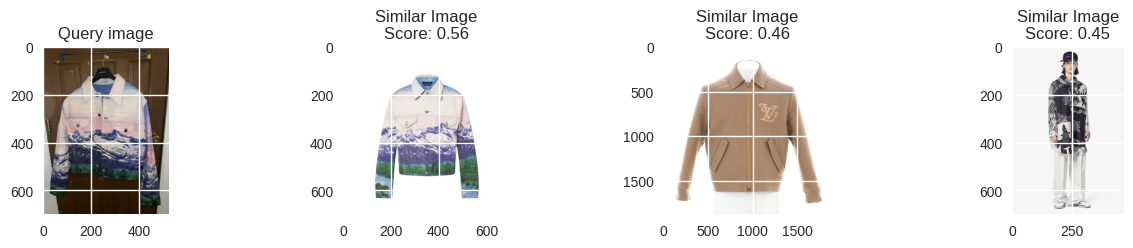

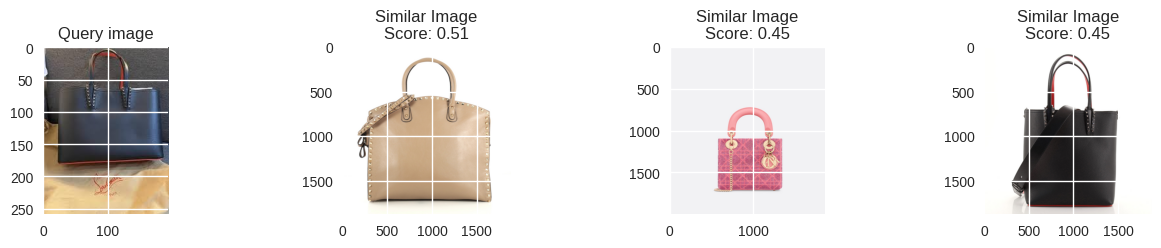

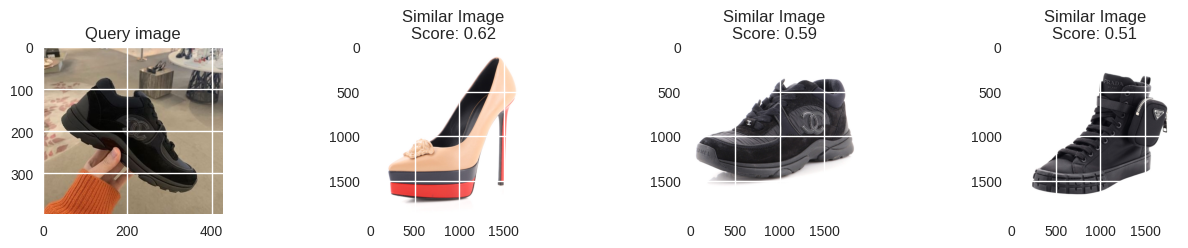

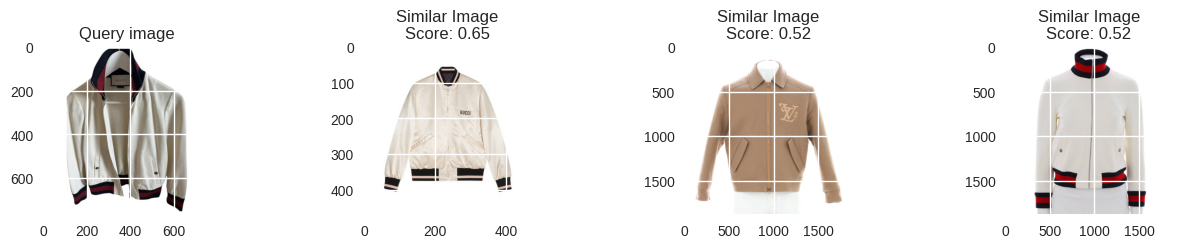

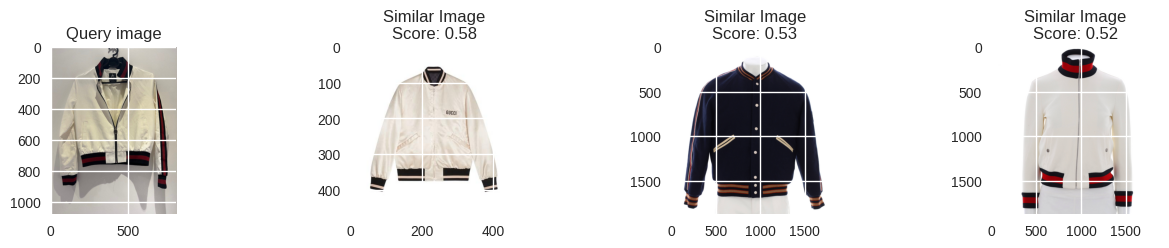

In [48]:
NUM_SIMULARITY = 3

for i, feature in enumerate(target_feature_list_compressed):
  result = index.query(
      vector=feature,
      top_k=NUM_SIMULARITY,
      include_values=False
  )
  images = []
  scores = []
  matches = result["matches"]
  images.append(mpimg.imread(target_filenames[i]))
  for found in matches:
    images.append(mpimg.imread('/content/drive/MyDrive/Datasets/test_task/source/' + found["id"]))
    scores.append(found["score"])


  plt.figure(figsize=(20, 10))
  num_rows = NUM_SIMULARITY + 1
  num_columns = len(target_feature_list_compressed)

  for j, image in enumerate(images):
    ax = plt.subplot(num_rows, num_columns, j + 1)
    if j == 0:
      ax.set_title("Query image")
    else:
      ax.set_title("Similar Image\n" + "Score: " + str(float("{0:.2f}".format(scores[j - 1]))))
    plt.imshow(image)
